# "저녁"시간대 유동인구의 추세(Cycle) 성분 예측

# 1. import library

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *

# 2. 데이터 불러오기

In [32]:
### morning data
with open('../data/preprocess/e_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)
data_list = append_cycle_size(data_list)
train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

# 3. 6가지 모델 훈련

In [39]:
trendcycle = 1
# trend일 때 0
# cycle일 때 1
tc_name = "cycle"
model_valid_scores = {f"linear_{tc_name}" : [],
                      f"svm_{tc_name}" : [],
                        f"xgboost_{tc_name}":[],
                         f"lstm_{tc_name}"   :[],
                          f"gru_{tc_name}"    :[],
                          f"lstm_fc_{tc_name}":[],}

## 1) Linear regression

In [40]:
from sklearn.linear_model import LinearRegression
model_name = f"linear_{tc_name}"

In [41]:
X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
y = np.array(train_y[:,:,trendcycle].cpu())
val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
val_y = np.array(valid_y[:,:,trendcycle].cpu())

# fitting
multioutputregressor = MultiOutputRegressor(LinearRegression()).fit(X, y)
# predicting
train_mse = np.mean((multioutputregressor.predict(X) - y)**2)
valid_mse = np.mean((multioutputregressor.predict(val_X) - val_y)**2)
print("train_mse: ", train_mse)
print("valid_mse: ", valid_mse)
model_valid_scores[model_name] = valid_mse

with open(f'best_model/{model_name}.pkl', 'wb') as f:
    pickle.dump(multioutputregressor, f)

train_mse:  0.0056289365
valid_mse:  0.01988096


## 2) SVM regressoion

In [42]:
from sklearn.svm import SVR
model_name =  f"svm_{tc_name}"

In [43]:
X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
y = np.array(train_y[:,:,trendcycle].cpu())
val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
val_y = np.array(valid_y[:,:,trendcycle].cpu())

# fitting
multioutputregressor = MultiOutputRegressor(SVR()).fit(X, y)
# predicting
train_mse = np.mean((multioutputregressor.predict(X) - y)**2)
valid_mse = np.mean((multioutputregressor.predict(val_X) - val_y)**2)
print("train_mse: ", train_mse)
print("valid_mse: ", valid_mse)
model_valid_scores[model_name] = valid_mse

with open(f'best_model/{model_name}.pkl', 'wb') as f:
    pickle.dump(multioutputregressor, f)

train_mse:  0.0038791282303436542
valid_mse:  0.01722349729575635


## 3) XGboost

In [44]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
model_name =  f"xgboost_{tc_name}"
            # trend일 때 0
            # cycle일 때 1

In [45]:
X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
y = np.array(train_y[:,:,trendcycle].cpu())
val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
val_y = np.array(valid_y[:,:,trendcycle].cpu())

# fitting
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X, y)
# predicting
train_mse = np.mean((multioutputregressor.predict(X) - y)**2)
valid_mse = np.mean((multioutputregressor.predict(val_X) - val_y)**2)
print("train_mse: ", train_mse)
print("valid_mse: ", valid_mse)
model_valid_scores[model_name] = valid_mse

with open(f'best_model/{model_name}.pkl', 'wb') as f:
    pickle.dump(multioutputregressor, f)

train_mse:  0.00020295815
valid_mse:  0.016132828


## 4) LSTM

In [46]:
from models.LSTM import LSTM
model = LSTM(input_size = 12, hidden_size = 32, no_time_size =4).to(device)
model_name = f"lstm_{tc_name}"

In [47]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)
num_epochs  = 500
hist = np.zeros(num_epochs)
train_error = []
valid_error = []
hist = {'best_val_error': 100,
        'best_val_epoch': 0}
for t in range(num_epochs):
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,trendcycle]) ### trend
    train_error.append(loss)
    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,trendcycle]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, f'best_model/{model_name}.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
        
best_model = torch.load( f'best_model/{model_name}.pkl')
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,trendcycle]))
print('valid_error : ',criterion(valid_pred, valid_y[:,:,trendcycle]))
model_valid_scores[model_name] = float(criterion(valid_pred, valid_y[:,:,trendcycle]).cpu())

10 Epochs train MSE: 0.02257 // valid MSE: 0.02466
20 Epochs train MSE: 0.01962 // valid MSE: 0.02310
30 Epochs train MSE: 0.01533 // valid MSE: 0.02066
40 Epochs train MSE: 0.01153 // valid MSE: 0.01922
50 Epochs train MSE: 0.00954 // valid MSE: 0.01971
60 Epochs train MSE: 0.00802 // valid MSE: 0.01928
70 Epochs train MSE: 0.00725 // valid MSE: 0.01737
80 Epochs train MSE: 0.00625 // valid MSE: 0.01732
90 Epochs train MSE: 0.00585 // valid MSE: 0.01795
100 Epochs train MSE: 0.00545 // valid MSE: 0.01773
110 Epochs train MSE: 0.00508 // valid MSE: 0.01737
120 Epochs train MSE: 0.00494 // valid MSE: 0.01976
130 Epochs train MSE: 0.00459 // valid MSE: 0.01807
140 Epochs train MSE: 0.00435 // valid MSE: 0.01864
150 Epochs train MSE: 0.00414 // valid MSE: 0.01994
160 Epochs train MSE: 0.00390 // valid MSE: 0.01983
170 Epochs train MSE: 0.00372 // valid MSE: 0.01969
180 Epochs train MSE: 0.00361 // valid MSE: 0.01960
190 Epochs train MSE: 0.00354 // valid MSE: 0.01943
200 Epochs train MSE:

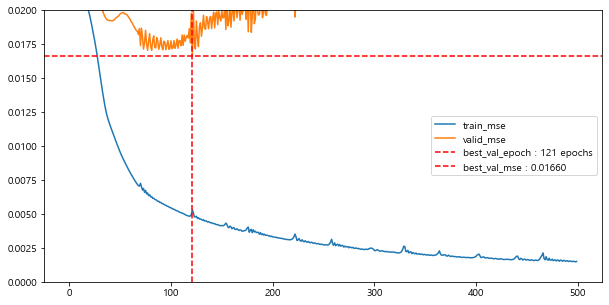

In [48]:
plot_hist(train_error, valid_error, hist, ylim = 0.02)

## 5) GRU

In [49]:
from models.GRU import GRU
model = GRU(input_size = 12, hidden_size = 32, no_time_size =4).to(device)
model_name =  f"gru_{tc_name}"

In [50]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)
num_epochs  = 500
hist = np.zeros(num_epochs)
train_error = []
valid_error = []
hist = {'best_val_error': 100,
        'best_val_epoch': 0}
for t in range(num_epochs):
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,trendcycle]) ### trend
    train_error.append(loss)
    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,trendcycle]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, f'best_model/{model_name}.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
        
best_model = torch.load( f'best_model/{model_name}.pkl')
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,trendcycle]))
print('valid_error : ',criterion(valid_pred, valid_y[:,:,trendcycle]))
model_valid_scores[model_name] = float(criterion(valid_pred, valid_y[:,:,trendcycle]).cpu())

10 Epochs train MSE: 0.02340 // valid MSE: 0.02515
20 Epochs train MSE: 0.02024 // valid MSE: 0.02331
30 Epochs train MSE: 0.01767 // valid MSE: 0.02158
40 Epochs train MSE: 0.01467 // valid MSE: 0.02047
50 Epochs train MSE: 0.01181 // valid MSE: 0.01929
60 Epochs train MSE: 0.00952 // valid MSE: 0.01833
70 Epochs train MSE: 0.00774 // valid MSE: 0.01722
80 Epochs train MSE: 0.00672 // valid MSE: 0.01626
90 Epochs train MSE: 0.00641 // valid MSE: 0.01677
100 Epochs train MSE: 0.00588 // valid MSE: 0.01622
110 Epochs train MSE: 0.00565 // valid MSE: 0.01662
120 Epochs train MSE: 0.00531 // valid MSE: 0.01633
130 Epochs train MSE: 0.00503 // valid MSE: 0.01707
140 Epochs train MSE: 0.00482 // valid MSE: 0.01804
150 Epochs train MSE: 0.00514 // valid MSE: 0.01629
160 Epochs train MSE: 0.00471 // valid MSE: 0.01860
170 Epochs train MSE: 0.00440 // valid MSE: 0.01689
180 Epochs train MSE: 0.00416 // valid MSE: 0.01753
190 Epochs train MSE: 0.00409 // valid MSE: 0.01704
200 Epochs train MSE:

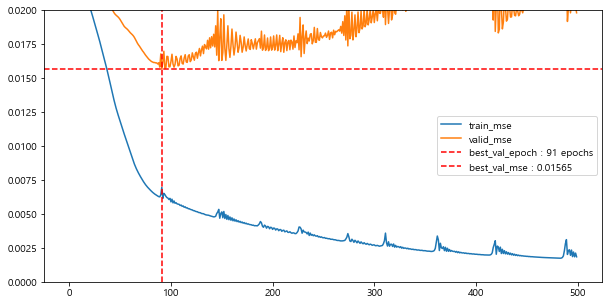

In [51]:
plot_hist(train_error, valid_error, hist, ylim = 0.02)

## 6) LSTM, FC 결합 모델

In [52]:
from models.LSTM_FC_cycle import LSTM_FC_cycle
model = LSTM_FC_cycle(input_size = 12, hidden_size = 32, no_time_size =4).to(device)
model_name = f'lstm_fc_{tc_name}'

In [53]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)
num_epochs  = 500
hist = np.zeros(num_epochs)
train_error = []
valid_error = []
hist = {'best_val_error': 100,
        'best_val_epoch': 0}
for t in range(num_epochs):
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,trendcycle]) ### trend
    train_error.append(loss)
    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,trendcycle]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, f'best_model/{model_name}.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
        
best_model = torch.load( f'best_model/{model_name}.pkl')
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,trendcycle]))
print('valid_error : ',criterion(valid_pred, valid_y[:,:,trendcycle]))
model_valid_scores[model_name] = float(criterion(valid_pred, valid_y[:,:,trendcycle]).cpu())

10 Epochs train MSE: 0.04404 // valid MSE: 0.04313
20 Epochs train MSE: 0.03055 // valid MSE: 0.02972
30 Epochs train MSE: 0.02755 // valid MSE: 0.02739
40 Epochs train MSE: 0.02732 // valid MSE: 0.02747
50 Epochs train MSE: 0.02642 // valid MSE: 0.02665
60 Epochs train MSE: 0.02601 // valid MSE: 0.02628
70 Epochs train MSE: 0.02533 // valid MSE: 0.02575
80 Epochs train MSE: 0.02439 // valid MSE: 0.02525
90 Epochs train MSE: 0.02326 // valid MSE: 0.02468
100 Epochs train MSE: 0.02228 // valid MSE: 0.02412
110 Epochs train MSE: 0.02063 // valid MSE: 0.02362
120 Epochs train MSE: 0.01939 // valid MSE: 0.02360
130 Epochs train MSE: 0.01879 // valid MSE: 0.02355
140 Epochs train MSE: 0.01830 // valid MSE: 0.02372
150 Epochs train MSE: 0.01766 // valid MSE: 0.02362
160 Epochs train MSE: 0.01623 // valid MSE: 0.02314
170 Epochs train MSE: 0.01483 // valid MSE: 0.02315
180 Epochs train MSE: 0.01343 // valid MSE: 0.02284
190 Epochs train MSE: 0.01219 // valid MSE: 0.02293
200 Epochs train MSE:

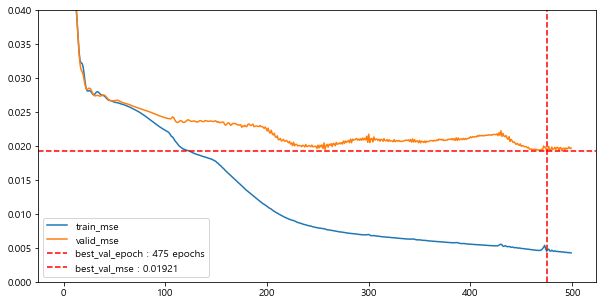

In [54]:
plot_hist(train_error, valid_error, hist, ylim = 0.04)

# 4. 6가지 모델의 검증데이터 성능 비교

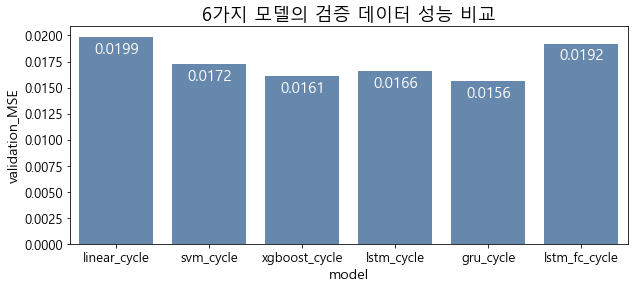

In [55]:
model_valid_scores = pd.DataFrame({"model"  : list(model_valid_scores.keys()),
                                    "validation_MSE": list(model_valid_scores.values())})
plot_models_valid_mse(model_valid_scores)
best_model_name = model_valid_scores.sort_values("validation_MSE").iloc[0]['model']

# 5. 훈련 데이터와 검증 데이터의 성능 비교

In [56]:
try:
    best_model = torch.load( f'best_model/{best_model_name}.pkl')
except:
    with open( f'best_model/{best_model_name}.pkl', 'rb') as f:
        best_model = pickle.load(f)

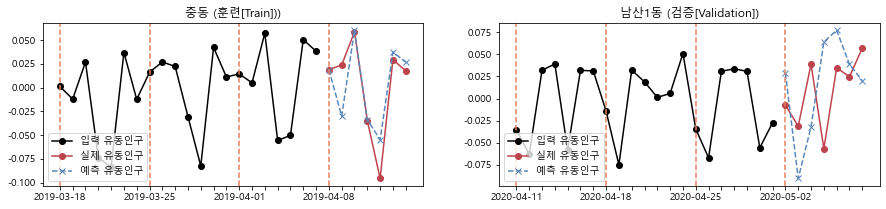

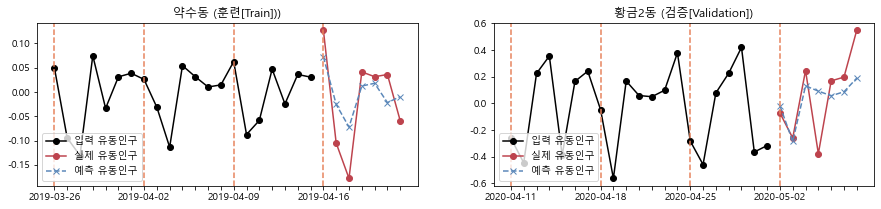

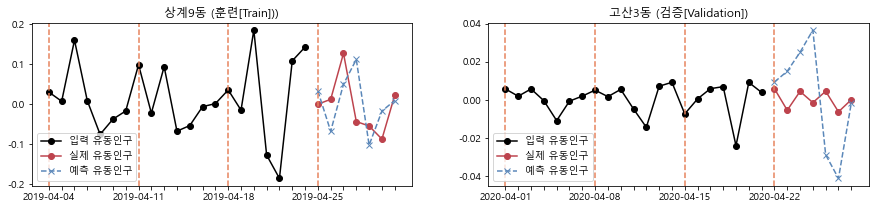

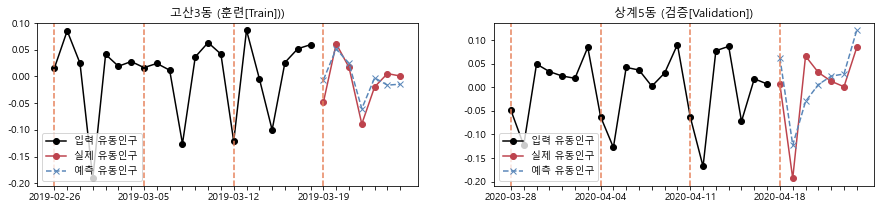

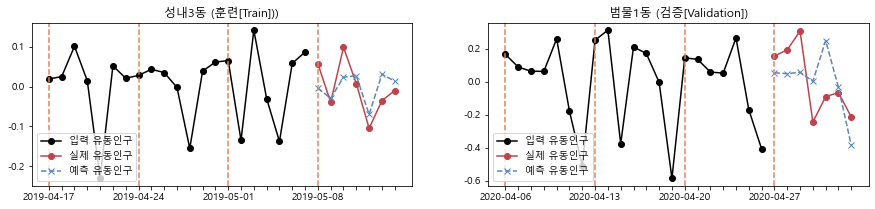

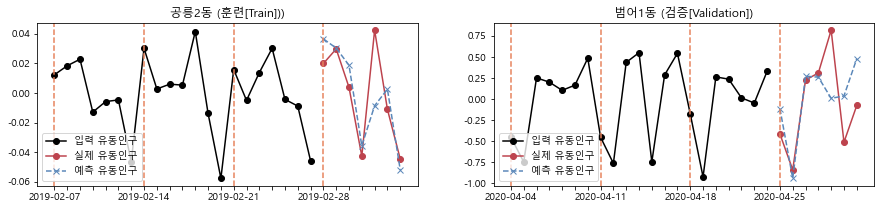

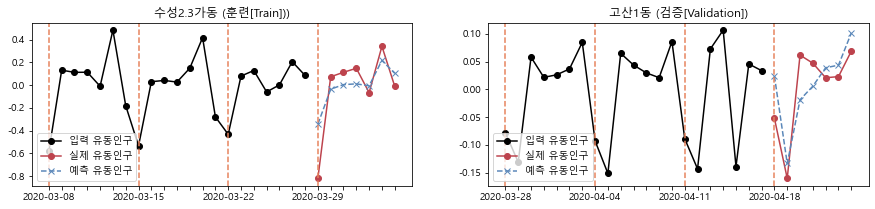

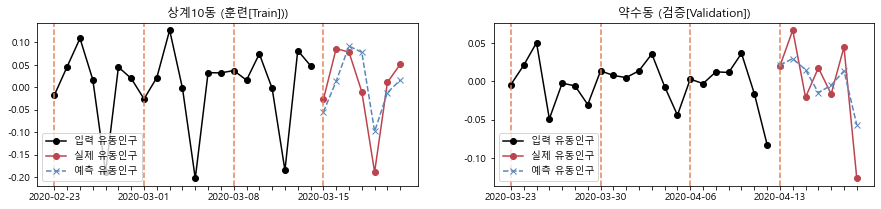

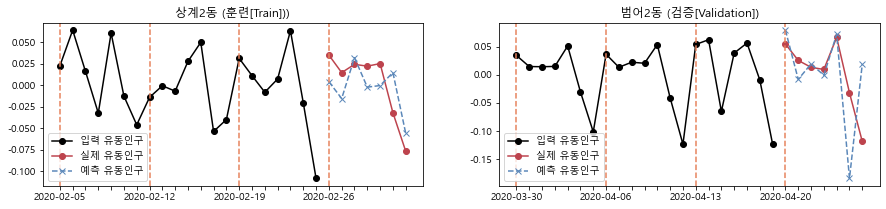

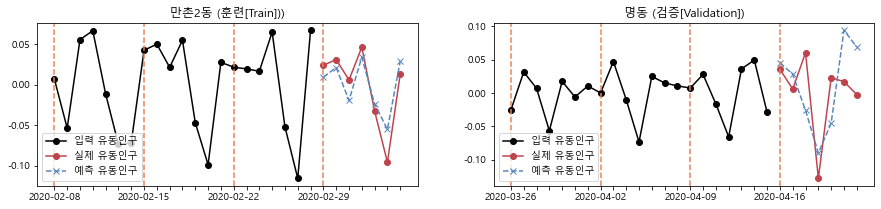

In [57]:
try:
    valid_trend_pred = best_model(valid_time, valid_notime)
    train_trend_pred = best_model(train_time, train_notime)
    
    train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np= tensor2numpy([train_time[:,:,trendcycle-2], train_y[:,:,trendcycle], train_trend_pred,
                                                            valid_time[:,:,trendcycle-2], valid_y[:,:,trendcycle], valid_trend_pred])
except:
    X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
    y = np.array(train_y[:,:,trendcycle].cpu())
    val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
    val_y = np.array(valid_y[:,:,trendcycle].cpu())
    
    train_pred = best_model.predict(X)
    valid_pred = best_model.predict(val_X)
    
    train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np = np.array(train_time[:,:,trendcycle-2].cpu()).reshape(-1,21), y, train_pred,\
                                                  np.array(valid_time[:,:,trendcycle-2].cpu()).reshape(-1,21), val_y, valid_pred, 
    
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

trend_result_list = [train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np]

### morning result
path = '../data/train_results/evening_results/'
with open(path + 'e_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(trend_result_list, f)

# 6. 평가(test set)

In [58]:
try:
    test_pred = best_model(test_time, test_notime)
    print('test_error : ',criterion(test_pred, test_y[:,:,trendcycle]))
except:
    test_x = np.array(test_time[:,:,:].cpu()).reshape(-1,21*12)
    test_pred = best_model.predict(test_x)
    print('test_error : ',np.mean(((test_pred) - (np.array(test_y[:,:,trendcycle].cpu())))**2))

test_error :  tensor(0.0142, device='cuda:0', grad_fn=<MseLossBackward>)


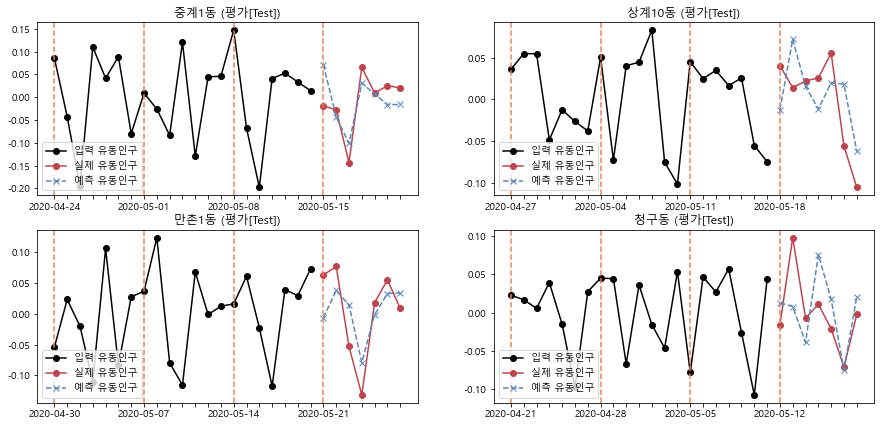

In [59]:
try:
    test_pred = best_model(test_time, test_notime)
    test_time_x_np, test_y_np, test_pred_np = tensor2numpy([test_time[:,:,trendcycle-2], test_y[:,:,trendcycle], test_pred])
except:
    testX, test_time_x_np, test_y_np = tensor2numpy([test_time, test_time[:,:,trendcycle-2], test_y[:,:,trendcycle]])
    test_pred_np = best_model.predict(testX.reshape(-1,21*12))

# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
trend_result_list = [test_time_x_np, test_y_np, test_pred_np]
path = '../data/train_results/evening_results/'
with open(path + 'e_cycle_results_test.pkl', 'wb') as f:
    pickle.dump(trend_result_list, f)

# 7. 6월 유동인구 주기(Cycle) 성분 예측

In [60]:
with open('../data/predict_june/preprocess_june/evening_june_time.pkl', 'rb') as f:
    train_time = pickle.load(f)
with open('../data/predict_june/preprocess_june/evening_june_notime.pkl', 'rb') as f:
    train_notime = pickle.load(f)

cycle_size =train_time[:,:,-2].max(axis = 1) - train_time[:,:, -2].min(axis = 1)
train_notime = np.concatenate([train_notime, cycle_size.reshape(-1,1)], axis = 1)

try:
    train_time_x, train_notime_x = numpy2tensor([train_time[:,:,3:].astype(np.float64), train_notime.astype(np.float64)])
    pred_y = best_model(train_time_x, train_notime_x)
    pred_y = np.array(pred_y.cpu().detach())
except:
    pred_y = best_model.predict(train_time[:,:,3:].astype(np.float64).reshape(-1,21*12))



path = '../data/predict_june/predict_cycle_trend/'
with open(path + 'june_evening_cycle_pred.pkl', 'wb') as f:
    pickle.dump(pred_y, f)